# Rivercats Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 12 # Rivercats

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              6435 non-null   int64  
 1   dimCustomerMasterId       6435 non-null   int64  
 2   customerNumber            6435 non-null   object 
 3   year                      6435 non-null   object 
 4   productGrouping           6435 non-null   object 
 5   totalSpent                6435 non-null   float64
 6   recentDate                6435 non-null   object 
 7   attendancePercent         6435 non-null   float64
 8   renewedBeforeDays         6435 non-null   int64  
 9   isBuyer                   6435 non-null   object 
 10  source_tenure             6435 non-null   int64  
 11  tenure                    6435 non-null   int64  
 12  distToVenue               6435 non-null   float64
 13  totalGames                6435 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          6435 non-null   int64  
 1   dimCustomerMasterId   6435 non-null   int64  
 2   customerNumber        6435 non-null   object 
 3   year                  6435 non-null   object 
 4   productGrouping       6435 non-null   object 
 5   totalSpent            6435 non-null   float64
 6   recentDate            6435 non-null   object 
 7   attendancePercent     6435 non-null   float64
 8   renewedBeforeDays     6435 non-null   int64  
 9   isBuyer               6435 non-null   object 
 10  source_tenure         6435 non-null   int64  
 11  tenure                6435 non-null   int64  
 12  distToVenue           6435 non-null   float64
 13  totalGames            6435 non-null   int64  
 14  recency               6435 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (5792, 49)
Unseen Data For Predictions: (643, 49)
Data for Modeling (A Class): (5792, 49)
Unseen Data For Predictions: (643, 49)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(6435, 23)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6435 non-null   int64  
 1   totalSpent           6435 non-null   float64
 2   attendancePercent    6435 non-null   float64
 3   renewedBeforeDays    6435 non-null   int64  
 4   source_tenure        6435 non-null   int64  
 5   tenure               6435 non-null   int64  
 6   totalGames           6435 non-null   int64  
 7   missed_games_1       6435 non-null   int64  
 8   missed_games_2       6435 non-null   int64  
 9   missed_games_over_2  6435 non-null   int64  
 10  isNextYear_Buyer     6435 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 553.1 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [9]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,totalSpent,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,0.11,0.04,0.03,0.16,0.29,0.13,0.09,0.10,0.11,0.11
totalSpent,0.11,1.00,-0.15,0.30,0.32,0.09,0.72,0.48,0.52,0.68,0.22
attendancePercent,0.04,-0.15,1.00,-0.07,-0.13,-0.08,0.24,0.14,-0.07,-0.45,0.05
renewedBeforeDays,0.03,0.30,-0.07,1.00,0.36,-0.08,0.37,0.29,0.26,0.32,0.33
source_tenure,0.16,0.32,-0.13,0.36,1.00,0.22,0.29,0.22,0.25,0.37,0.25
tenure,0.29,0.09,-0.08,-0.08,0.22,1.00,0.07,0.04,0.04,0.11,-0.21
totalGames,0.13,0.72,0.24,0.37,0.29,0.07,1.00,0.75,0.60,0.46,0.28
missed_games_1,0.09,0.48,0.14,0.29,0.22,0.04,0.75,1.00,0.53,0.28,0.21
missed_games_2,0.10,0.52,-0.07,0.26,0.25,0.04,0.60,0.53,1.00,0.42,0.19
missed_games_over_2,0.11,0.68,-0.45,0.32,0.37,0.11,0.46,0.28,0.42,1.00,0.19


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [10]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5148, 11)
Unseen Data For Predictions: (1287, 11)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [11]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=["totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,6592
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5148, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(False,
 <MLUsecase.CLASSIFICATION: 1>,
 'box-cox',
 None,
 True,
 {'lr': <pycaret.containers.models.classification.LogisticRegressionClassifierContainer at 0x7f96d697d450>,
  'knn': <pycaret.containers.models.classification.KNeighborsClassifierContainer at 0x7f96d697df90>,
  'nb': <pycaret.containers.models.classification.GaussianNBClassifierContainer at 0x7f96d697d390>,
  'dt': <pycaret.containers.models.classification.DecisionTreeClassifierContainer at 0x7f96d5e0c750>,
  'svm': <pycaret.containers.models.classification.SGDClassifierContainer at 0x7f96d697d5d0>,
  'rbfsvm': <pycaret.containers.models.classification.SVCClassifierContainer at 0x7f96d68580d0>,
  'gpc': <pycaret.containers.models.classification.GaussianProcessClassifierContainer at 0x7f96d69941d0>,
  'mlp': <pycaret.containers.models.classification.MLPClassifierContainer at 0x7f96d6858290>,
  'ridge': <pycaret.containers.models.classification.RidgeClassifierContainer at 0x7f96d687db90>,
  'rf': <pycaret.containers.models

In [12]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,Gradient Boosting Classifier,0.7962,0.8830,0.7341,0.7504,0.7418,0.5736,0.5741,0.1220
8,NGBClassifier,0.7921,0.8801,0.7177,0.7507,0.7334,0.5633,0.5640,1.4830
5,Light Gradient Boosting Machine,0.7885,0.8794,0.7353,0.7352,0.7350,0.5590,0.5593,0.0350
7,Random Forest Classifier,0.7873,0.8790,0.7220,0.7392,0.7300,0.5546,0.5552,0.2480
0,Ada Boost Classifier,0.7829,0.8726,0.7244,0.7300,0.7268,0.5467,0.5472,0.0520
9,Extreme Gradient Boosting,0.7817,0.8734,0.7256,0.7270,0.7260,0.5446,0.5450,0.3890
3,Extra Trees Classifier,0.7678,0.8548,0.6922,0.7170,0.7037,0.5131,0.5139,0.2110
1,Decision Tree Classifier,0.7375,0.7280,0.6812,0.6687,0.6744,0.4546,0.4552,0.0090
4,K Neighbors Classifier,0.6693,0.7100,0.5955,0.5854,0.5900,0.3130,0.3133,0.0490
6,Logistic Regression,0.6008,0.4302,0.0000,0.0000,0.0000,0.0000,0.0000,0.0070


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [13]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8398,0.9130,0.7622,0.8224,0.7911,0.6615,0.6628
1,0.7888,0.8706,0.7134,0.7452,0.7290,0.5561,0.5565
2,0.8107,0.8968,0.7561,0.7654,0.7607,0.6041,0.6042
3,0.7621,0.8363,0.6707,0.7143,0.6918,0.4985,0.4991
4,0.8325,0.9128,0.7758,0.8000,0.7877,0.6495,0.6497
5,0.8155,0.9000,0.8121,0.7486,0.7791,0.6212,0.6227
6,0.8058,0.8963,0.7636,0.7545,0.7590,0.5964,0.5965
7,0.7597,0.8679,0.6727,0.7115,0.6916,0.4950,0.4955
8,0.7494,0.8464,0.6829,0.6871,0.6850,0.4769,0.4769
9,0.7981,0.8895,0.7317,0.7547,0.7430,0.5768,0.5770


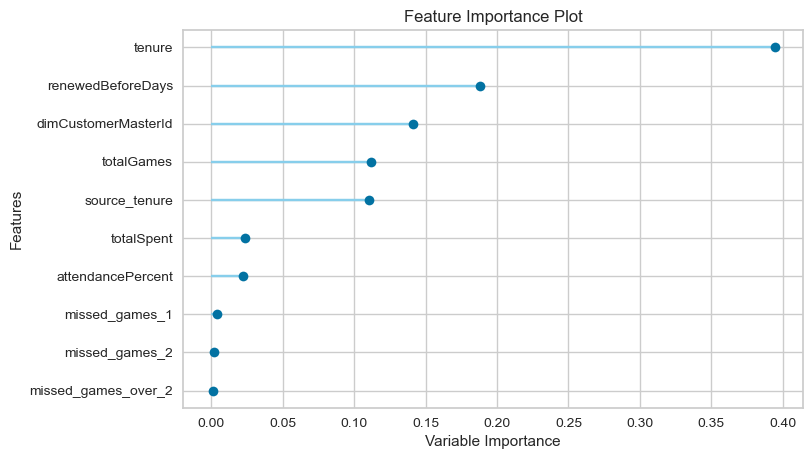

In [14]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?